In [17]:
!pip install pathway bokeh --quiet
!pip install bokeh --quiet

In [18]:
import pandas as pd

df = pd.read_csv("dataset.csv")
df.head()


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [19]:
df.columns = df.columns.str.lower()
df['timestamp'] = pd.to_datetime(
    df['lastupdateddate'] + ' ' + df['lastupdatedtime'],
    format="%d-%m-%Y %H:%M:%S",
    errors='coerce'
)
df = df.sort_values('timestamp').reset_index(drop=True)
df['t'] = df['timestamp']
df['day'] = df['t'].dt.normalize()


MODEL 1

In [20]:
def BaselineModelPrice(occupancy, capacity, alpha=5, base_price=10):
    ratio = occupancy / capacity
    if ratio < 1:
        return round(base_price + alpha * ratio, 2)
    else:
        return round(base_price + alpha, 2)
df['base_price'] = 10
df['new_price'] = df.apply(
    lambda row: BaselineModelPrice(
        row['occupancy'],
        row['capacity'],
        alpha=5,
        base_price=row['base_price']
    ),
    axis=1
)
display(df[['occupancy', 'capacity', 'base_price', 'new_price']].head())

,occupancy,capacity,base_price,new_price
0,61,577,10,10.53
1,237,1200,10,10.99
2,264,687,10,11.92
3,249,485,10,12.57
4,614,1920,10,11.60


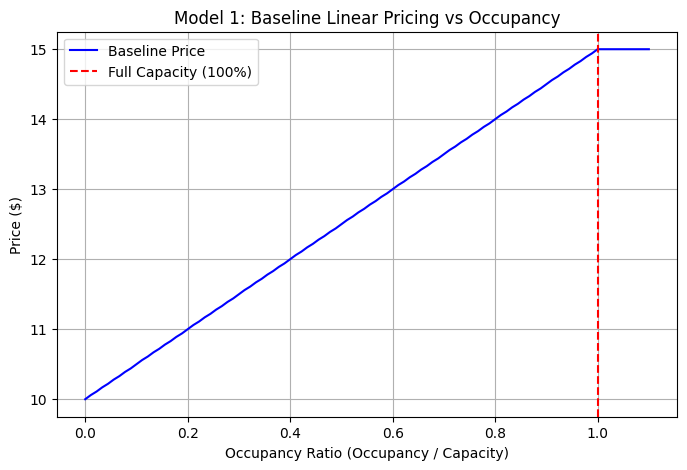

In [21]:
import numpy as np
import matplotlib.pyplot as plt
occupancies = np.linspace(0, 1.1, 100)

prices = [BaselineModelPrice(o, capacity=1) for o in occupancies]  # Use capacity = 1 for ratio

plt.figure(figsize=(8, 5))
plt.plot(occupancies, prices, label='Baseline Price', color='blue')
plt.axvline(1.0, linestyle='--', color='red', label='Full Capacity (100%)')
plt.xlabel('Occupancy Ratio (Occupancy / Capacity)')
plt.ylabel('Price ($)')
plt.title('Model 1: Baseline Linear Pricing vs Occupancy')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# MODEL 2

In [23]:
def get_vehicle_weight(vehicle_type):
    weights = {'car': 1.0, 'bike': 0.6, 'truck': 1.8}
    return weights.get(str(vehicle_type).lower(), 1.0)

def get_traffic_weight(traffic_level):
    # Higher traffic = less likely to park so lower weights
    weights = {'low': 1.0, 'average': 0.7, 'high': 0.5}
    return weights.get(str(traffic_level).lower(), 1.0)

def nonlinear_demand_score(row):
    ratio = row['occupancy'] / row['capacity']
    occ_component = 1 / (1 + np.exp(-10 * (ratio - 0.6)))  # sigmoid centered at 0.6
    queue_component = 1.05 ** min(row['queuelength'], 10)  # capped at queue = 10
    traffic_component = get_traffic_weight(row['trafficconditionnearby'])
    vehicle_component = get_vehicle_weight(row['vehicletype'])
    special_day_component = 1.2 if row['isspecialday'] else 1.0
    demand_score = occ_component * queue_component * traffic_component * vehicle_component * special_day_component
    return min(demand_score, 5.0)  # cap extreme outliers


In [24]:
def model2_price_bounded(row, base_price=10):
    demand_score = nonlinear_demand_score(row)  # capped at 5
    bounded_factor = 0.8 + (demand_score / 5) * 1.2  # scales from 0.8x to 2.0x
    return round(base_price * bounded_factor, 2)


In [25]:
df['model2_price'] = df.apply(model2_price_bounded, axis=1)


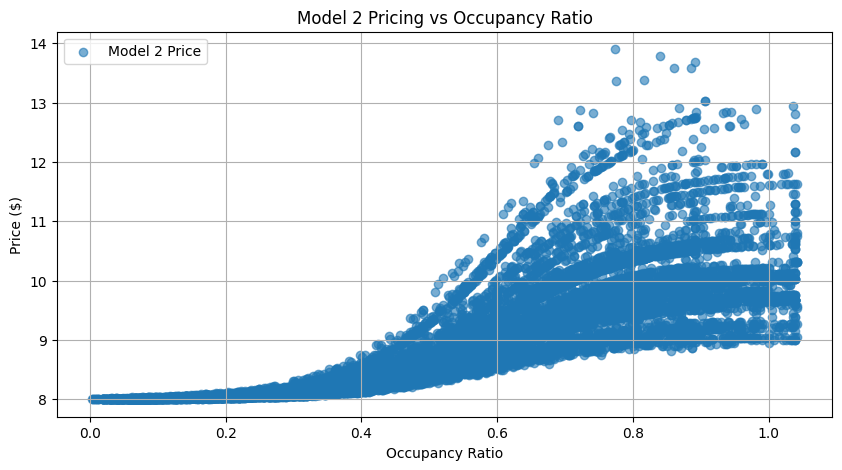

In [26]:
df['model2_price'] = df.apply(model2_price_bounded, axis=1)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(df['occupancy'] / df['capacity'], df['model2_price'], alpha=0.6, label='Model 2 Price')
plt.xlabel("Occupancy Ratio")
plt.ylabel("Price ($)")
plt.title("Model 2 Pricing vs Occupancy Ratio")
plt.grid(True)
plt.legend()
plt.show()


In [27]:
df['lot_id'] = df.groupby(['latitude', 'longitude']).ngroup()


In [28]:

df['model2_price'] = 10 + 5 * (df['occupancy'] / df['capacity'])  # Simplified Model 2

# Save cleaned dataset for Pathway
cleaned_path = "dataset.csv"
df[['timestamp', 'lot_id', 'occupancy', 'capacity', 'model2_price']].to_csv(cleaned_path, index=False)



Model 3

In [29]:
# Haversine for Nearby Lot Mapping
from math import radians, cos, sin, asin, sqrt
import json

# Haversine distance in km
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

# Generate nearby_map: {lot_id: [nearby_lot_ids]}
locations = df[['lot_id', 'latitude', 'longitude']].drop_duplicates()
nearby_map = {}

for i, row in locations.iterrows():
    lot_i = row['lot_id']
    nearby = []
    for j, r2 in locations.iterrows():
        if row['lot_id'] == r2['lot_id']:
            continue
        d = haversine(row['latitude'], row['longitude'], r2['latitude'], r2['longitude'])
        if d <= 2:  # within 2 km
            nearby.append(r2['lot_id'])
    nearby_map[lot_i] = nearby

# Save for reference (optional)
with open("nearby_map.json", "w") as f:
    json.dump(nearby_map, f)

In [40]:
# Model 3 Competitive Logic (Separate Cell)
def model3_competitor_logic(lot_id, timestamp, occupancy, capacity, model2_price):
    ratio = occupancy / capacity
    nearby_ids = nearby_map.get(str(lot_id)) or nearby_map.get(int(lot_id)) or []
    competitors = df[
        (df['lot_id'].isin(nearby_ids)) &
        (df['timestamp'] == timestamp)
    ]

    if competitors.empty:
        return model2_price

    avg_price = competitors['model2_price'].mean()
    cheaper_exists = (competitors['model2_price'] < model2_price).any()

    if ratio >= 1 and cheaper_exists:
        return round(model2_price * 0.95, 2)
    elif ratio < 1 and avg_price > model2_price:
        return round(model2_price * 1.05, 2)
    else:
        return model2_price

In [30]:
# 🚦 STEP 4: Pathway Real-Time Simulation
import pathway as pw

class PricingStream:
    def run(self, input_stream: pw.Table) -> pw.Table:
        table = input_stream.select(
            timestamp=input_stream.timestamp,
            lot_id=input_stream.lot_id,
            occupancy=input_stream.occupancy,
            capacity=input_stream.capacity,
            model2_price=input_stream.model2_price
        )

        def price_logic(row):
            ratio = row.occupancy / row.capacity
            if ratio >= 1:
                return round(row.model2_price * 0.95, 2)
            elif ratio < 1:
                return round(row.model2_price * 1.05, 2)
            return row.model2_price

        table += table.select(
            model3_price=pw.apply(price_logic, table)
        )

        return table.select(
            timestamp=table.timestamp,
            lot_id=table.lot_id,
            model3_price=table.model3_price
        )
        input_table = pw.io.csv.read(
    "dataset.csv",
    schema=pw.Schema(
        timestamp=str,
        lot_id=int,
        occupancy=float,
        capacity=float,
        model2_price=float
    ),
    mode="streaming",
    autocommit_duration_ms=1000
).with_timestamp_from_isoformat("timestamp")



In [31]:
import pathway as pw

# Define schema
class ParkingSchema(pw.Schema):
    timestamp: str
    lot_id: int
    occupancy: float
    capacity: float
    model2_price: float

# Read the input CSV
input_table = pw.io.csv.read(
    "dataset.csv",
    schema=ParkingSchema,
    mode="streaming",
    autocommit_duration_ms=10000
)

# Add a dummy time column if needed (optional for sorting/windowing)
data = input_table.with_columns(t = pw.this.timestamp)

# Define the pricing logic
def model3_logic(occupancy, capacity, model2_price):
    ratio = occupancy / capacity
    if ratio >= 1:
        return round(model2_price * 0.95, 2)
    elif ratio < 1:
        return round(model2_price * 1.05, 2)
    return model2_price

# Apply the logic
output = data.with_columns(
    model3_price = pw.apply(
        model3_competitor_logic,
        data.lot_id, data.timestamp, data.occupancy, data.capacity, data.model2_price
    )
)


# Output the streaming result
pw.io.csv.write(
    table=output.select(
        timestamp = pw.this.timestamp,
        lot_id = pw.this.lot_id,
        model3_price = pw.this.model3_price
    ),
    filename="model3_price.csv"
)



pw.run() #In order to get bokeh plot we would need to stop this cell manually after running it atleast for a minute.


Output()

KeyboardInterrupt: 

In [32]:
# 📈 Bokeh Plot: Model 3 Price Over Time per Lot
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category10
import pandas as pd

output_notebook()

# Load streamed prices
df_prices = pd.read_csv("model3_price.csv")
df_prices['timestamp'] = pd.to_datetime(df_prices['timestamp'])

# Create figure
p = figure(x_axis_type='datetime', title='Model 3 Price Over Time per Lot',
           width=800, height=400)

p.xaxis.axis_label = 'Timestamp'
p.yaxis.axis_label = 'Model 3 Price (₹)'

# Plot each lot_id separately
palette = Category10[10]
for i, lot_id in enumerate(df_prices['lot_id'].unique()):
    df_lot = df_prices[df_prices['lot_id'] == lot_id]
    source = ColumnDataSource(df_lot)
    color = palette[i % len(palette)]
    p.line(x='timestamp', y='model3_price', source=source, legend_label=f"Lot {lot_id}", line_width=2, color=color)

p.legend.title = 'Parking Lots'
p.legend.location = 'top_left'

show(p)


In [33]:
# Bokeh Plot: Average Revenue per Lot
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.layouts import column

# Merge occupancy into price data
df_merged = pd.merge(df_prices, df[['timestamp', 'lot_id', 'occupancy']], on=['timestamp', 'lot_id'])
df_merged['revenue'] = df_merged['model3_price'] * df_merged['occupancy']

# Compute average revenue per lot
avg_revenue = df_merged.groupby('lot_id')['revenue'].mean().reset_index()
source = ColumnDataSource(avg_revenue)

# Bar chart
p_rev = figure(x_range=[str(lid) for lid in avg_revenue['lot_id']],
               title="Average Revenue per Lot (Model 3)",
               x_axis_label="Lot ID", y_axis_label="Average Revenue (₹)",
               height=400, width=800)

p_rev.vbar(x='lot_id', top='revenue', width=0.5, source=source, color="#87CEEB")
p_rev.xaxis.major_label_orientation = 1

show(p_rev)


In [34]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

plots = []

# ✅ Sort lot IDs before plotting
for lot_id in sorted(df_prices['lot_id'].unique()):
    df_lot = df_prices[df_prices['lot_id'] == lot_id]
    source = ColumnDataSource(df_lot)
    p = figure(x_axis_type='datetime', title=f"Lot {lot_id}", width=400, height=200)
    p.line(x='timestamp', y='model3_price', source=source, line_width=2)
    p.xaxis.axis_label = 'Timestamp'
    p.yaxis.axis_label = 'Price'
    plots.append(p)

# Arrange in grid: 2 per row
grid = gridplot([plots[i:i+2] for i in range(0, len(plots), 2)])
show(grid)


In [37]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20
import pandas as pd

output_notebook()

def plot_latest_model3_price():
    try:
        df = pd.read_csv("model3_price.csv")
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        p = figure(x_axis_type='datetime', width=900, height=500,
                   title="Model 3 Price Over Time (Click to Mute Any Lot)",
                   tools="pan,wheel_zoom,box_zoom,reset,save")

        palette = Category20[20]  # up to 20 lots
        for i, lot_id in enumerate(sorted(df['lot_id'].unique())):
            df_lot = df[df['lot_id'] == lot_id]
            source = ColumnDataSource(df_lot)
            p.line(x='timestamp', y='model3_price', source=source,
                   legend_label=f"Lot {lot_id}",
                   line_width=2,
                   color=palette[i % len(palette)],
                   muted_alpha=0.2)

        p.legend.location = "top_left"
        p.legend.click_policy = "mute"
        p.xaxis.axis_label = "Timestamp"
        p.yaxis.axis_label = "Model 3 Price (₹)"
        show(p)

    except Exception as e:
        print(f"⚠️ Error loading/plotting: {e}")


In [38]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Range1d, DateRangeSlider, CustomJS
from bokeh.layouts import column
from bokeh.palettes import Category20
import pandas as pd
import datetime

output_notebook()

# Load and prepare data
df = pd.read_csv("model3_price.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Setup plot
p = figure(x_axis_type='datetime', width=900, height=500,
           title="Model 3 Price Over Time with Date Range Slider",
           tools="pan,wheel_zoom,box_zoom,reset,save")

p.xaxis.axis_label = "Timestamp"
p.yaxis.axis_label = "Model 3 Price (₹)"
p.legend.click_policy = "mute"

# Create one data source for all lines
palette = Category20[20]
sources = []
renderers = []

for i, lot_id in enumerate(sorted(df['lot_id'].unique())):
    df_lot = df[df['lot_id'] == lot_id]
    src = ColumnDataSource(df_lot)
    line = p.line('timestamp', 'model3_price', source=src,
                  color=palette[i % len(palette)],
                  line_width=2,
                  legend_label=f"Lot {lot_id}",
                  muted_alpha=0.2)
    sources.append(src)
    renderers.append(line)

p.legend.location = "top_left"

# Create a DateRangeSlider
start_date = df['timestamp'].min()
end_date = df['timestamp'].max()
range_slider = DateRangeSlider(title="Date Range", start=start_date, end=end_date,
                                value=(start_date, end_date), step=1)

# JS callback to filter x-range dynamically
callback = CustomJS(args=dict(p=p, slider=range_slider), code="""
    const [start, end] = slider.value;
    p.x_range.start = start;
    p.x_range.end = end;
""")
range_slider.js_on_change("value", callback)

# Show layout
show(column(range_slider, p))


/tmp/ipython-input-38-823322531.py:21: UserWarning: 
You are attempting to set `plot.legend.click_policy` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  p.legend.click_policy = "mute"
